# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


# 1. Introduction

## 1.1 Project Brief


Tasty Bytes Product Manager is responsible for choosing which recipes to display on the home page each day, and asked if the data science team could help him with that. Today, he chooses his favorite recipe from a selection and they have noticed that the website's traffic goes up by as much 40% if a popular recipe is picked.

Main goals:
- Predict which recipes leads to high traffic
- Correctly predict high traffic recipes 80% of the time

## 1.2 Data description

| Column Name  | Details                                                                                                                                                                                                |
|--------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| recipe       | Numeric, unique identifier of recipe                                                                                                                                                                   |
| calories     | Numeric, number of calories                                                                                                                                                                            |
| carbohydrate | Numeric, amount of carbohydrates in grams                                                                                                                                                              |
| sugar        | Numeric, amount of sugar in grams                                                                                                                                                                      |
| protein      | Numeric, amount of protein in grams                                                                                                                                                                    |
| category     | Character, type of recipe. Recipes are listed in one of ten possible groupings (Lunch/Snacks', 'Beverages', 'Potato', 'Vegetable', 'Meat', 'Chicken, 'Pork', 'Dessert', 'Breakfast', 'One Dish Meal'). |
| servings     | Numeric, number of servings for the recipe                                                                                                                                                             |
| high_traffic | Character, if the traffic to the site was high when this recipe was shown, this is marked with “High”.                                                                                                 |

# 2. Data Processing

## 2.1 Loading the data

In [157]:
# Import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (15,8)
color = sns.color_palette('viridis')

sns.set(palette=color)


In [158]:
# Load and explore data

recipes = pd.read_csv('recipe_site_traffic_2212.csv')
df = recipes.copy()
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


## 2.2 Data Cleaning and Feature Engineering

In [159]:
df = df.drop(columns='recipe')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   calories      895 non-null    float64
 1   carbohydrate  895 non-null    float64
 2   sugar         895 non-null    float64
 3   protein       895 non-null    float64
 4   category      947 non-null    object 
 5   servings      947 non-null    object 
 6   high_traffic  574 non-null    object 
dtypes: float64(4), object(3)
memory usage: 51.9+ KB
None


The column "recipe" was dropped because it is just an unique identifier and will not be used in our model.

We can see that the "servings" and "high_traffic" columns has object data type, so they will need some manipulation.

In [160]:
print(df['servings'].value_counts())

df['servings'] = df['servings'].str.replace(' as a snack','').astype('int')

servings
4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: count, dtype: int64


Analysing the servings column there were some rows with text, the text was removed and the column converted to int datatype.

In [161]:
print(df['high_traffic'].value_counts())
df['high_traffic'] = df['high_traffic'].apply(lambda x: 1 if x == 'High' else 0 )

high_traffic
High    574
Name: count, dtype: int64


The recipes that were categorized as high_traffic have the word 'High', we convert these rows to 1 and any other row value including nans to 0 to be used in our model as the responsible variable.

In [162]:
print(df['category'].unique())

df['category'] = df['category'].str.replace('Chicken Breast','Chicken')

['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Chicken' 'Vegetable' 'Meat' 'Dessert']



The 'Chicken Breast' category are not in the Data description as a avalible category, so we changed all the values of this category to be 'Chicken'

## 2.3 Handling missing values

In [163]:
print(df.isnull().sum())

# fill the nan values with the median value from each correponding category

df_filled = df.copy()
df_filled['calories'] = df['calories'].fillna(df.groupby('category')['calories'].transform('median'))
df_filled['carbohydrate'] = df['carbohydrate'].fillna(df.groupby('category')['carbohydrate'].transform('median'))
df_filled['sugar'] = df['sugar'].fillna(df.groupby('category')['sugar'].transform('median'))
df_filled['protein'] = df['protein'].fillna(df.groupby('category')['protein'].transform('median'))
   

calories        52
carbohydrate    52
sugar           52
protein         52
category         0
servings         0
high_traffic     0
dtype: int64


All the missing values are concentrated in the same rows for the columns 'calories', 'carbohydrate', 'sugar', and 'protein'. These missing values occur together, suggesting a potential systematic issue with data collection or recording.

There are 52 rows with nan values and this corresponds to about 5.5% of the total rows in the dataset. We can drop the nan rows completely or impute some value like the mean or median. 

To avoid losing what could be valuable information, I opted to fill the nan values with the median of each corresponding category. The idea is that each recipe belonging to the category has ingredients in common, bringing the data closer to reality and preserving some existing relationship between the variables.

This approach must be validated and compared with other treatments in the model's evaluation phase.

# 3. Exploratory Data Analysis

## 3.1 Summary statistics

In [164]:
df_filled.describe()


,calories,carbohydrate,sugar,protein,servings,high_traffic
count,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000
mean,431.085544,34.449625,8.888728,23.938786,3.477297,0.606125
std,441.366521,42.846480,14.371911,35.473402,1.732741,0.488866
min,0.140000,0.030000,0.010000,0.000000,1.000000,0.000000
25%,114.410000,9.135000,1.795000,3.465000,2.000000,0.000000
50%,296.920000,21.190000,4.400000,11.240000,4.000000,1.000000
75%,576.225000,42.590000,9.565000,29.820000,4.000000,1.000000
max,3633.160000,530.420000,148.750000,363.360000,6.000000,1.000000


Using the describe function is a fast way to give summary statistics from the dataset numerical features. Looking at it we can see that the max value is very distant from the means in calories, carbohydrate, sugar and protein columns.

## 3.2 Distributions

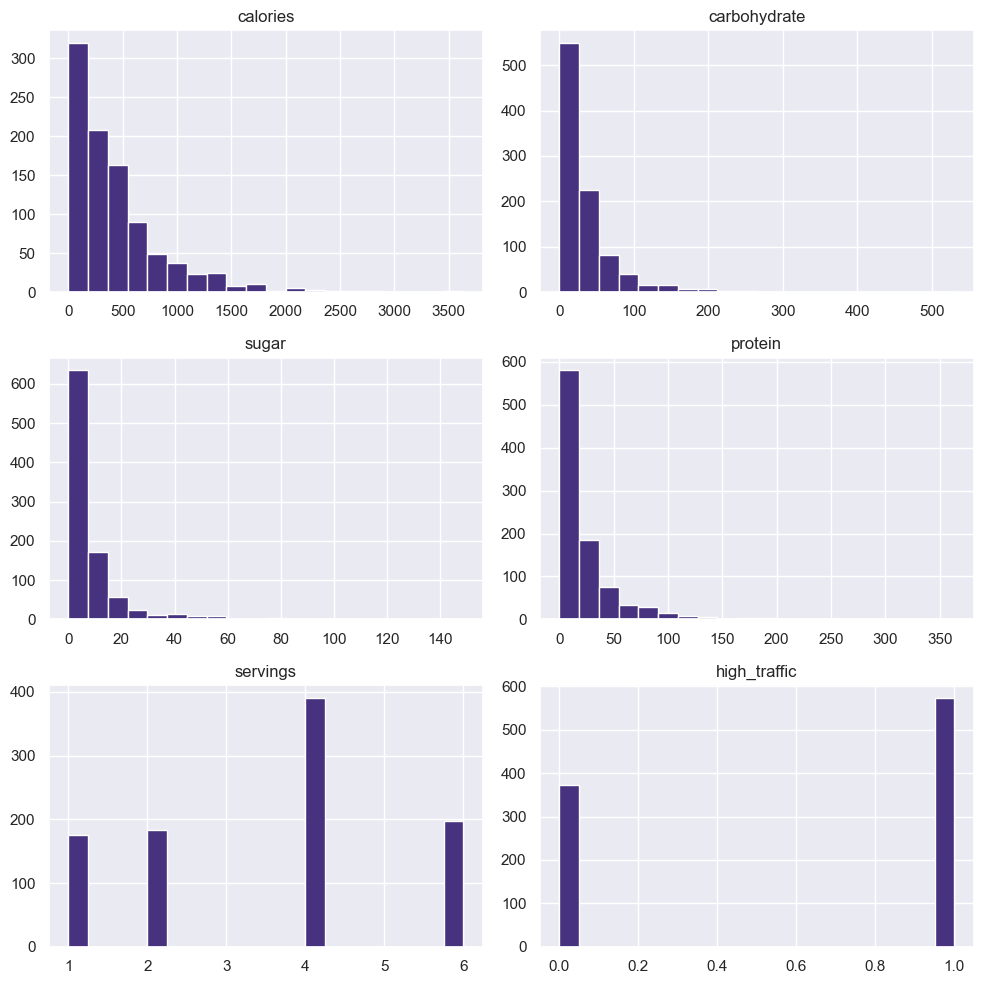

calories        2.111087
carbohydrate    3.872229
sugar           4.290695
protein         3.589141
dtype: float64


In [165]:
df_filled.hist(figsize=(10,10), bins=20)
plt.tight_layout()
plt.show()

print(df_filled[['calories','carbohydrate','sugar','protein']].skew())

The first four columns have high right skewed distributions and will need further analysis.

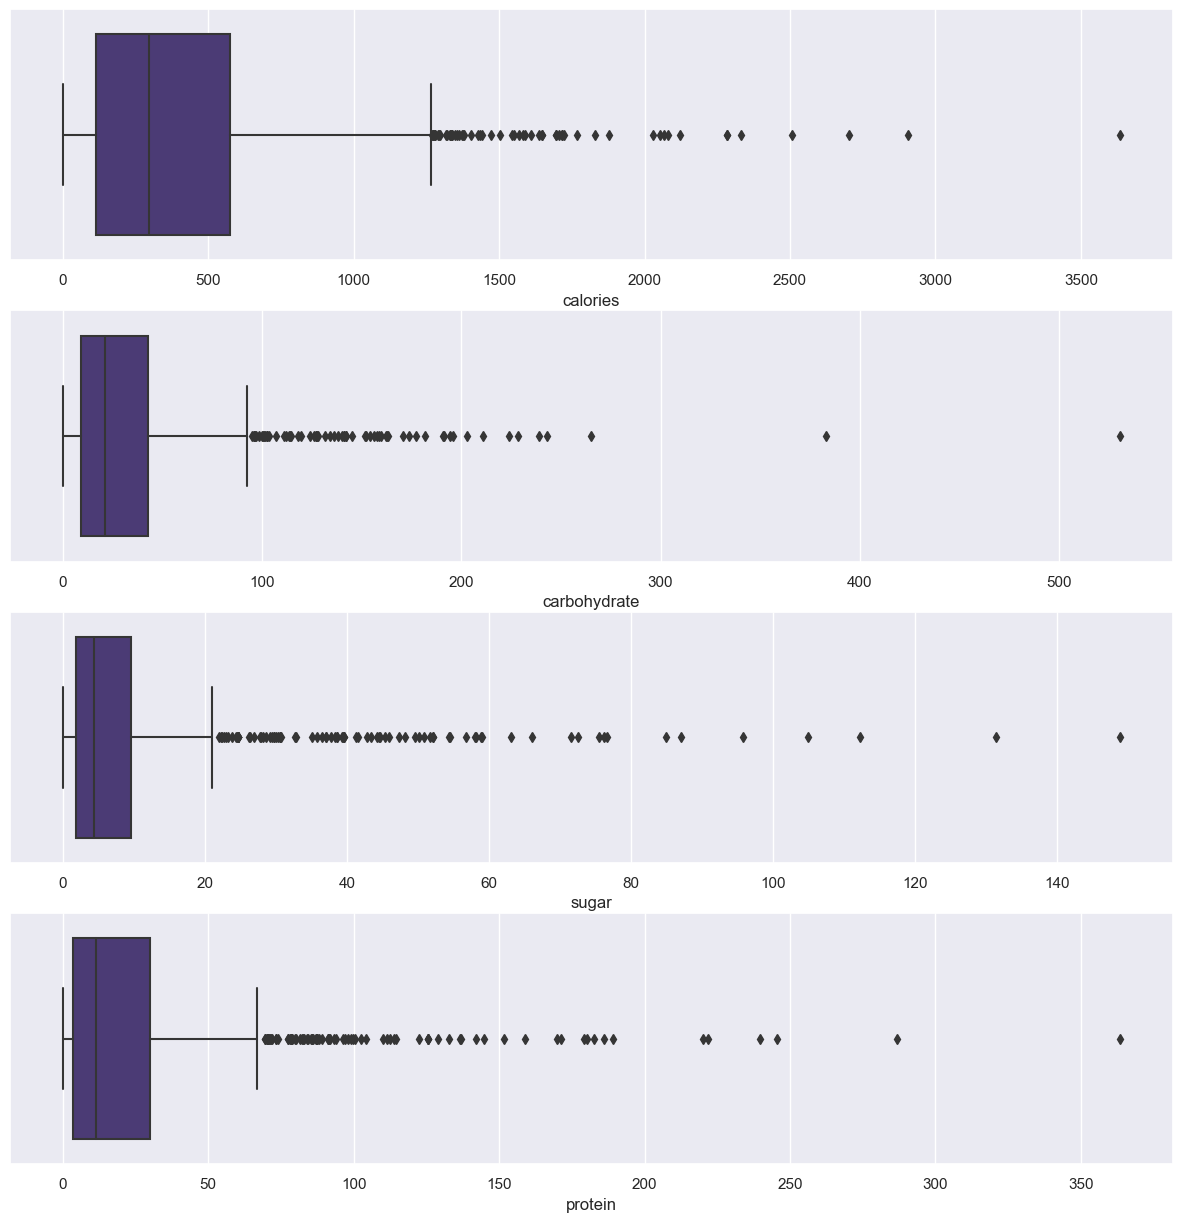

In [166]:
fig, ax = plt.subplots(4,1,figsize=(15,15))
sns.boxplot(data=df_filled, x='calories', ax=ax[0])
sns.boxplot(data=df_filled, x='carbohydrate', ax=ax[1])
sns.boxplot(data=df_filled, x='sugar', ax=ax[2])
sns.boxplot(data=df_filled, x='protein', ax=ax[3])
plt.show()

The boxplots show a high number of outliers in each of the columns.

The nature of the data is very diverse and can vary greatly due to factors such as inumerous different ingredients in each recipe and preparation methods. In that sense, it would be very difficult to categorize these outliers as data entry errors.

With the high number of outliers, removing them is not a viable option as this would introduce great loss of information and could affect the model performance.

It is generally considered good practice to address outliers in a dataset as they have the potential to significantly impact model performance. However, for the purpose of this project, we have decided to evaluate the model's performance without treating outliers. This choice allows us to establish a baseline and compare it with future iterations of the project, where we will explore the effects of outlier treatment.


In [167]:
from scipy import stats

def boxcox_transformation(df_aux):
    df2 = df_aux.copy()
    df2['calories'] = pd.Series(stats.boxcox(df_filled['calories'])[0])
    df2['carbohydrate'] = pd.Series(stats.boxcox(df_filled['carbohydrate'])[0])
    df2['sugar'] = pd.Series(stats.boxcox(df_filled['sugar'])[0])
    protein_bc = df_filled['protein'] - df_filled['protein'].min() + 0.01
    df2['protein'] = pd.Series(stats.boxcox(protein_bc)[0])
    return df2

def show_dist(df2):
    fig, ax = plt.subplots(4,1,figsize=(15,15))
    sns.boxplot(data=df2, x='calories', ax=ax[0])
    sns.boxplot(data=df2, x='carbohydrate', ax=ax[1])
    sns.boxplot(data=df2, x='sugar', ax=ax[2])
    sns.boxplot(data=df2, x='protein', ax=ax[3])
    plt.show()
    
    df2.hist(figsize=(10,10), bins=20)
    plt.tight_layout()
    plt.show()

    print(df2[['calories','carbohydrate','sugar','protein']].skew())


In [174]:
def remove_outliers(df):
    df_removed = df.copy()
    numeric_cols = df_removed.select_dtypes(include=['number']).columns
    Q1 = df_removed[numeric_cols].quantile(0.25)
    Q3 = df_removed[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - (IQR * 1.5)
    upper = Q3 + (IQR * 1.5)
    df_removed[numeric_cols] = np.where(df_removed[numeric_cols] > upper, upper, df_removed[numeric_cols])
    return df_removed

Here I have implemented two functions to transform the dataset. The first function applies a Box-Cox transformation to bring the data closer to the normal distribution and reduces the impact of extreme values. This transformation aims to make the data more suitable for modeling purposes.

The second function applies the Winsorize method, which is used to handle extreme values or outliers. In this case, the extreme values are replaced with the threshold value at the 95th percentile of each feature. This approach helps reduce the influence of outliers on the models.

Although both transformation methods were applied individually during model training, they did not result in significant improvements in the model performance for this particular project. However, they can be valuable tools to explore in future iterations of the project. By refining and iterating on these transformations, we may uncover potential performance enhancements and gain deeper insights into the data.

The project will proceed without any of theses transformation at the time.



## 3.3 Categories Analysis

Now we have to deal with the categorical values. we are going to verify the distribution of recipes among categories. If there are any categories with extremely higher or lower counts, this could affect our model. 

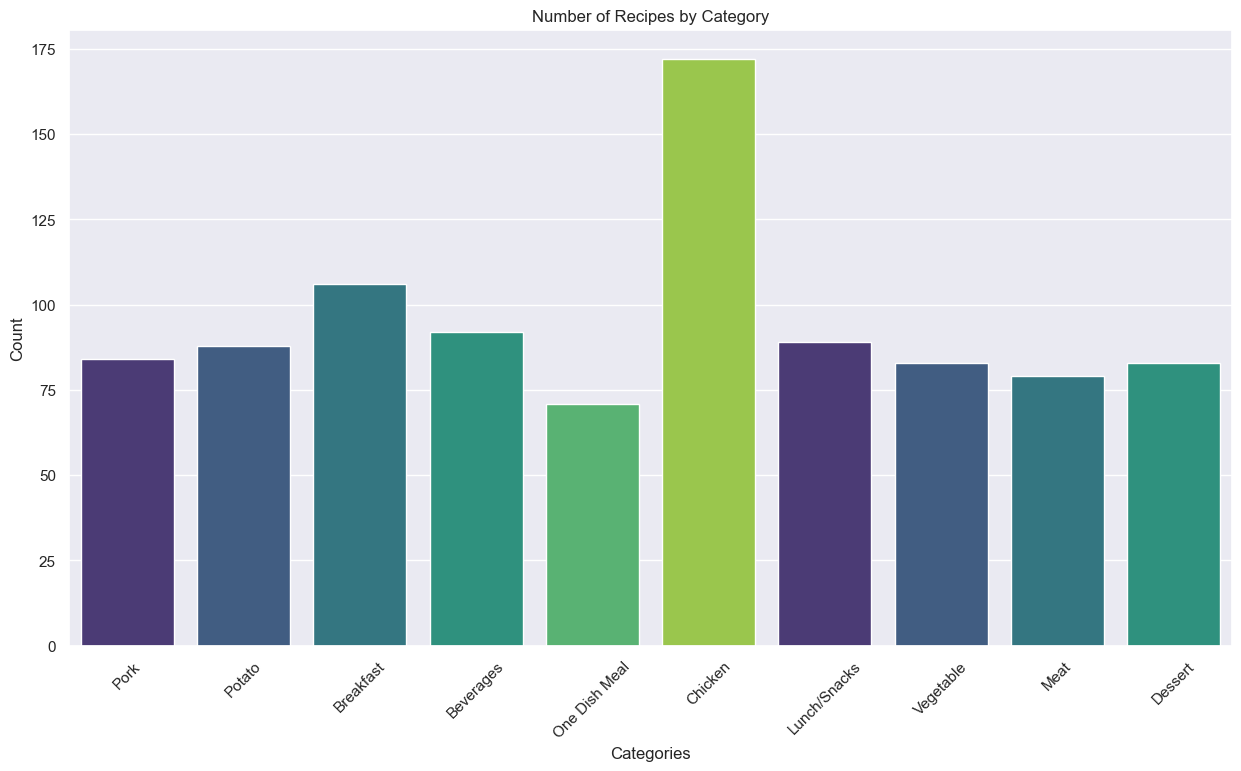

In [169]:

sns.countplot(data=df_filled, x='category', palette=color)
plt.xticks(rotation=45)
plt.title('Number of Recipes by Category')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

With the transformation in the 'Chicken Breast' category, we see that the chicken category has many more recipes than others

The next step is compare the total number of high traffic recipes with the number in each category.

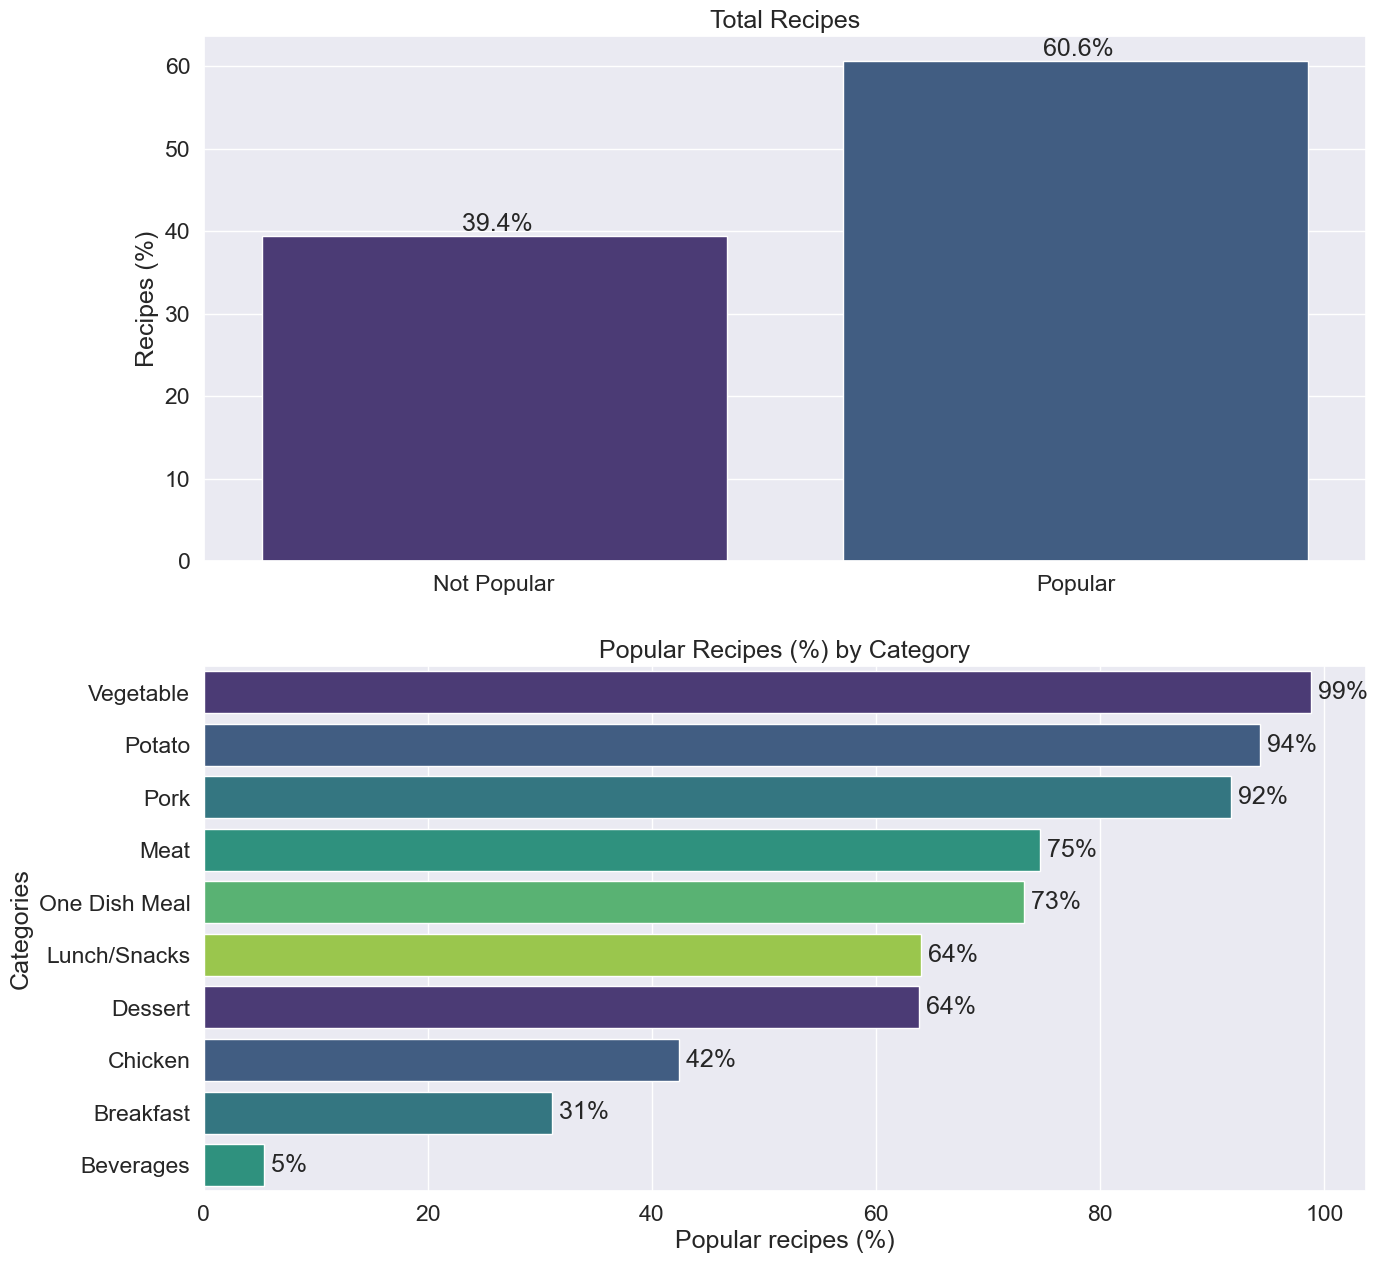

In [184]:
sns.set_theme(style='darkgrid', font_scale=1.5)

fig, ax = plt.subplots(2,1, figsize=(15,15))

high_traffic_total_perc = df_filled['high_traffic'].mean()*100
total_high_traffic = pd.DataFrame({ 'Not Popular': [100-high_traffic_total_perc], 'Popular': [high_traffic_total_perc]})


sns.barplot(data=total_high_traffic, ax=ax[0], palette=color)
ax[0].set_title('Total Recipes')
ax[0].set_ylabel('Recipes (%)')

ax[0].bar_label(ax[0].containers[0], fmt=' %.1f%%')

cat_high_traffic = df_filled.groupby('category')['high_traffic'].mean().reset_index().sort_values('high_traffic',ascending=False)
cat_high_traffic['high_traffic'] = cat_high_traffic['high_traffic'] * 100
sns.barplot(data=cat_high_traffic, y='category', x='high_traffic', ax=ax[1], palette=color)
ax[1].set_title('Popular Recipes (%) by Category')
ax[1].set_ylabel('Categories')
ax[1].set_xlabel('Popular recipes (%)')
ax[1].bar_label(ax[1].containers[0], fmt=' %.0f%%')

plt.show()

The first plot shows the total number of high traffic recipes in the dataset. About 60.6% of the recipes were considered as high traffic, this number can be used later for the evaluation of the model.

The second plot shows the percentage of high traffic recipes in each category. We see that some categories have a much higher number of high traffic recipes, especially the categories 'Pork', 'Potato' and 'Vegetable' that have more than 90%. On the other end, categories like 'Chicken','Breakfast' and 'Beverages' have a much lower amount.

## 3.4 Correlation

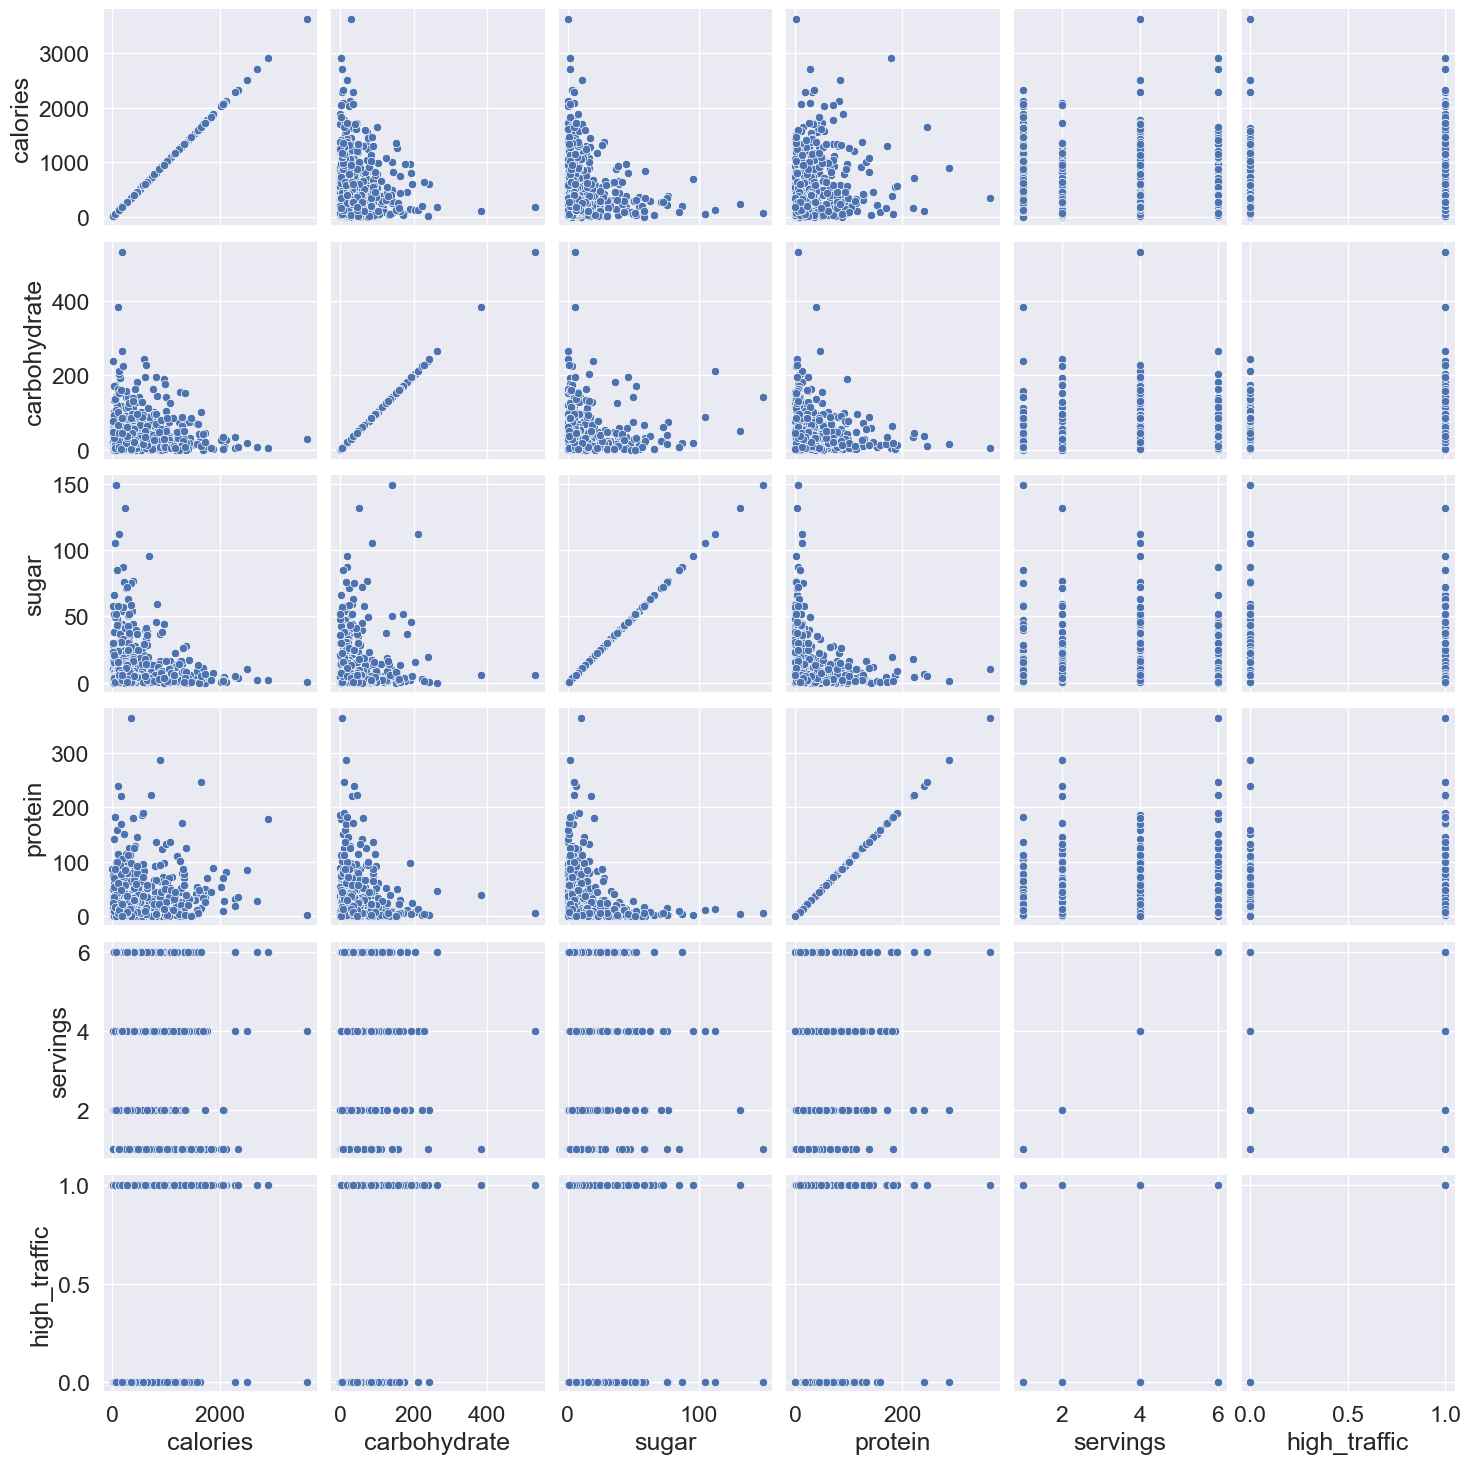

In [171]:
sns.pairplot(data=df_filled, diag_kind=None, kind='scatter', palette=color)
plt.show()

Executing a pairplot scatter between the features can provide valuable insights into the relationships and interactions between different features in the dataset. The scatterplot above do not shows any sign of strong linear correlation between features.

Veryfiing the person's correlation in the dataset could give us a hint of what the most important features for a recipe to be considered high traffic or not.

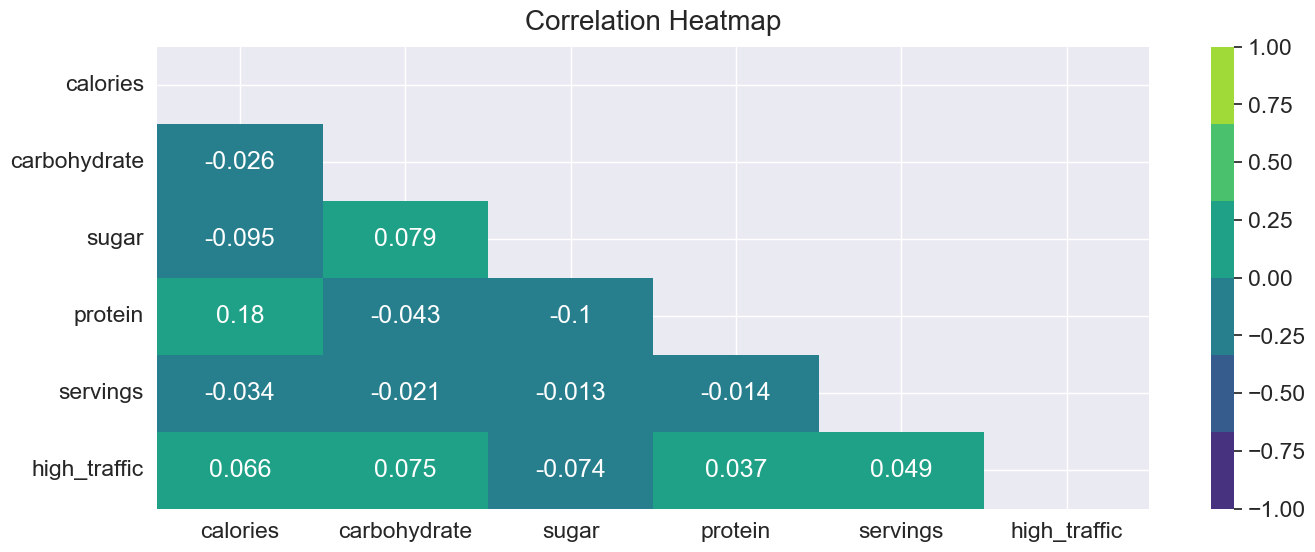

In [172]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df_filled.select_dtypes(include=['number']).corr()))
heatmap = sns.heatmap(df_filled.select_dtypes(include=['number']).corr(), vmin=-1, vmax=1, annot=True, mask=mask, cmap=color)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12);

As can be seen in the heatmap above, there is a very small correlation between the model's numerical features, suggesting that there is little or weak linear relationship between them.

# 4. Model Development

## 4.1 Model Selection

This project focuses on predicting whether a recipe will be popular or not. Given that it involves **binary classification**, **logistic regression** emerges as a suitable choice for this task.

In addition to logistic regression, we will also employ the **RandomForestClassifier** model. This decision is driven by its robustness to outliers and its ability to identify the most important features within the dataset.

## 4.2 Selection of variables

In [175]:
df_filled2 = remove_outliers(df_filled)
display(df_filled.max())
display(df_filled2.max())


calories          3633.16
carbohydrate       530.42
sugar              148.75
protein            363.36
category        Vegetable
servings                6
high_traffic            1
dtype: object

calories        1268.9475
carbohydrate      92.7725
sugar               21.22
protein           69.3525
category        Vegetable
servings              6.0
high_traffic          1.0
dtype: object

In [179]:
y = df_filled['high_traffic']
X = pd.get_dummies(df_filled.drop('high_traffic', axis=1))

## 4.3 Spliting the data into training and testing sets

In [180]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, roc_curve, auc, classification_report
from sklearn.metrics import roc_auc_score

seed = 37
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=seed, stratify=y)

# scale the train and test splits 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Model Evaluation

## 5.1 Evaluation Metrics

For this project, Tasty Bytes wants to show the maximum number of high traffic recipes as possible. In this case, the metric that would better fit the problem would be precision.

A higher precision implies that the model is effective in identifying high traffic recipes without incorrectly labeling non-high traffic recipes as high traffic.

Additionally, we can use the AUC-ROC to assess the model's ability to distinguish between high traffic and non-high traffic recipes across different threshold values. A higher AUC-ROC indicates better discrimination power and a greater ability to rank instances correctly.

Regarding the dataset, it contains approximately 60.6% of high traffic recipes. This proportion serves as our baseline for comparison against the performance of the two models. By evaluating how well our models perform in relation to this baseline, we can gain insights into their effectiveness in predicting high traffic recipes.

In [ ]:
def show_plots(y_pred,fpr,tpr,auc_score,feature_importance, model_name ):
        
        cols = X.columns
        sns.barplot(x=feature_importance,y=cols, palette=color)
        plt.title('Feature Importance')
        plt.ylabel('Feature Name')
        plt.xlabel('Importance')
        plt.xticks(rotation=90)
        plt.show()
        
        cnf_matrix = confusion_matrix(y_test, y_pred)

        fig, ax = plt.subplots(1,2,figsize=(15,5))
        # Plot a labeled confusion matrix with Seaborn
        sns.heatmap(cnf_matrix, annot=True, fmt="g", ax=ax[0], cmap=color)
        ax[0].set_title("Confusion matrix")
        ax[0].set_ylabel("Actual label")
        ax[0].set_xlabel("Predicted label")
        #print(classification_report(y_test,y_pred))

        ax[1].plot(fpr, tpr, label= model_name)
        ax[1].legend(labels=[f'AUC = {auc_score:.3f}'], loc='upper left' )
        ax[1].plot([0,1],[0,1],'k--')
        ax[1].set_xlabel('False Positive Rate')

        ax[1].set_ylabel('True Positive Rate')
        ax[1].set_title(model_name + ' ROC Curve')
        plt.show()

In [ ]:
import time
def run_pred(X_train, y_train, ml_model,n):
    t0=time.time()
    model = ml_model
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    cv_f1 = cross_val_score(model,X_train, y_train, cv=n, scoring='f1')
    cv_f1_weighted = cross_val_score(model,X_train, y_train, cv=n, scoring='f1_weighted')
    cv_roc_auc=cross_val_score(model,X_train, y_train, cv=n, scoring='roc_auc')
    cv_log_loss=cross_val_score(model,X_train, y_train, cv=n, scoring='neg_log_loss')
    cv_accuracy=cross_val_score(model,X_train, y_train, cv=n, scoring='accuracy')
    cv_precison=cross_val_score(model,X_train, y_train, cv=n, scoring='precision')
    cv_recall=cross_val_score(model,X_train, y_train, cv=n, scoring='recall')
    time_taken = time.time()-t0
    print(f'{type(ml_model).__name__} CV Scores:')
    print(f'f1: {cv_f1.mean()}')
    print(f'f1 Weighted: {cv_f1_weighted.mean()}')
    print(f'AUC: {cv_roc_auc.mean()}')
    print(f'Log loss: {cv_log_loss.mean()}')
    print(f'Accuracy: {cv_accuracy.mean()}')
    print(f'Precision: {cv_precison.mean()}')
    print(f'Recall: {cv_recall.mean()}')
    print(f'\n')
    # print("Time taken = {}".format(time_taken))
    # print(f'\n')
    return y_pred

## 5.2 Logistic Regression

In [182]:
logreg_pred = run_pred(X_train, y_train, LogisticRegression(),5)

LogisticRegression CV Scores:
f1: 0.8043989006229741
f1 Weighted: 0.7643520863673932
AUC: 0.8280679191528248
Log loss: -0.482826353069021
Accuracy: 0.7643996354522671
Precision: 0.8073700327960267
Recall: 0.8030864197530864




In [181]:
logreg_pred = run_pred(X_train, y_train, LogisticRegression(),10)

LogisticRegression CV Scores:
f1: 0.8038754834201407
f1 Weighted: 0.7618565163629764
AUC: 0.8270971440483637
Log loss: -0.4887641931477427
Accuracy: 0.7629127091813659
Precision: 0.8085326648593313
Recall: 0.8032317073170733




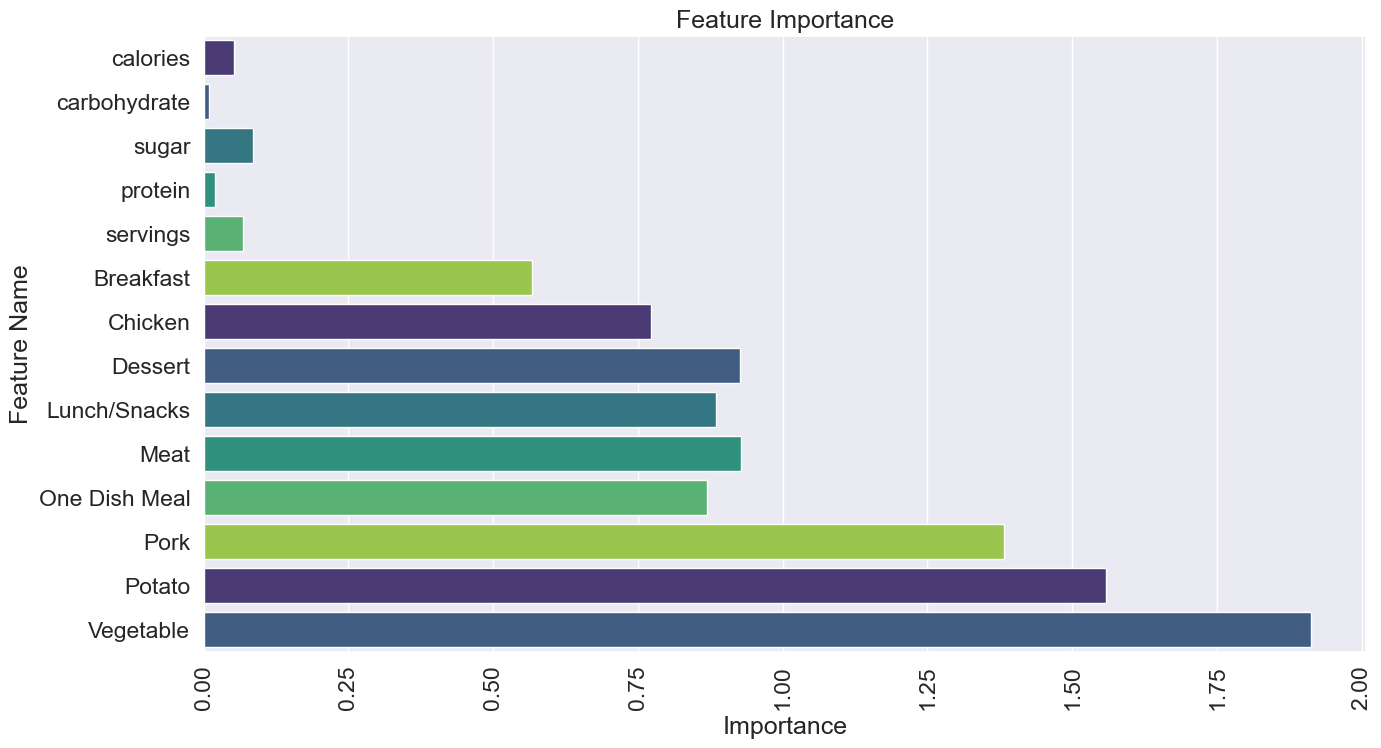

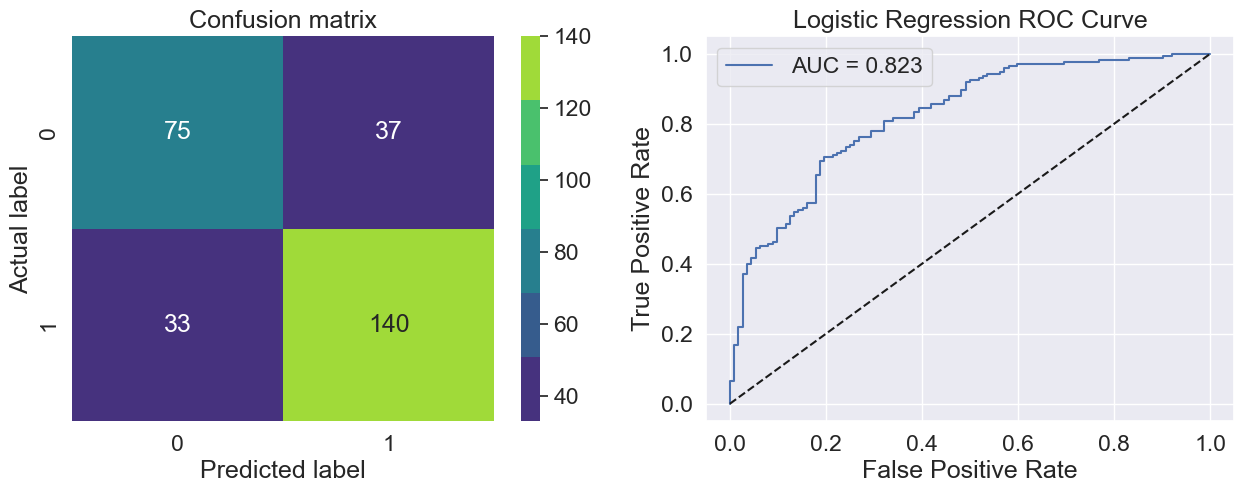

Logistic Regression Precision Score: 79.1%
Logistic Regression Precision Cross Val Score: 80.7%
Logistic Regression ROC AUC: 82.3%


In [ ]:
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)

lr_y_pred = lr.predict(X_test_scaled)
lr_y_pred_prob = lr.predict_proba(X_test_scaled)[:,1]
lr_fpr, lr_tpr, lr_tresholds = roc_curve(y_test, lr_y_pred_prob)
lr_auc_score = auc(lr_fpr,lr_tpr)
lr_cv = cross_val_score(lr,X_train_scaled,y_train, scoring='precision', cv=5)
lr_cv_score = lr_cv.mean()*100

lr_results = pd.DataFrame( {
    'model': 'Logistic Regression',
    'Precision':precision_score(y_test,lr_y_pred)*100,
    'AUC':lr_auc_score*100,
    'CV Precision': lr_cv_score
}, index=[0])

feature_importance = np.abs(lr.coef_[0])

show_plots(lr_y_pred, lr_fpr,lr_tpr, lr_auc_score, feature_importance,'Logistic Regression')
print(f"Logistic Regression Precision Score: {lr_results['Precision'][0]:.1f}%")
print(f"Logistic Regression Precision Cross Val Score: {lr_cv_score:.1f}%")
print(f"Logistic Regression ROC AUC: {lr_results['AUC'][0]:.1f}%")



In [ ]:
print(classification_report(y_test, lr_y_pred))

              precision    recall  f1-score   support

           0       0.69      0.67      0.68       112
           1       0.79      0.81      0.80       173

    accuracy                           0.75       285
   macro avg       0.74      0.74      0.74       285
weighted avg       0.75      0.75      0.75       285



The feature importance analysis using Logistic Regression highlights the significance of certain category columns in predicting recipe popularity. Specifically, the categories of vegetable, potato, and pork emerge as the most influential features. This aligns with our previous findings, as these categories exhibited a notably higher proportion of popular recipes compared to others.

In the Confusion Matrix plot, we observe that the model accurately predicted 140 out of 177 recipes as high traffic in the test set, resulting in a precision score of 79.1%. This indicates that the model is capable of identifying high traffic recipes with a relatively high level of accuracy.

To validate the precision score obtained, a cross_val_score was performed, yielding a precision score of 80.7%. This score provides a more reliable estimate of the model's precision performance, considering the evaluation across multiple folds.

The third plot depicts an AUC-ROC score of 82.6%. This score suggests that the model exhibits a strong ability to rank instances correctly, regardless of the threshold values used. It further validates the model's effectiveness in differentiating between high traffic and non-high traffic recipes.

The combination of the Confusion Matrix, AUC-ROC score, and cross_val_score reinforces the model's capability in accurately predicting high traffic recipes, with the precision score serving as a consistent metric for its performance.

## 5.3 RandomForestClassifier

We will do the same process for the RandomForestClassifier

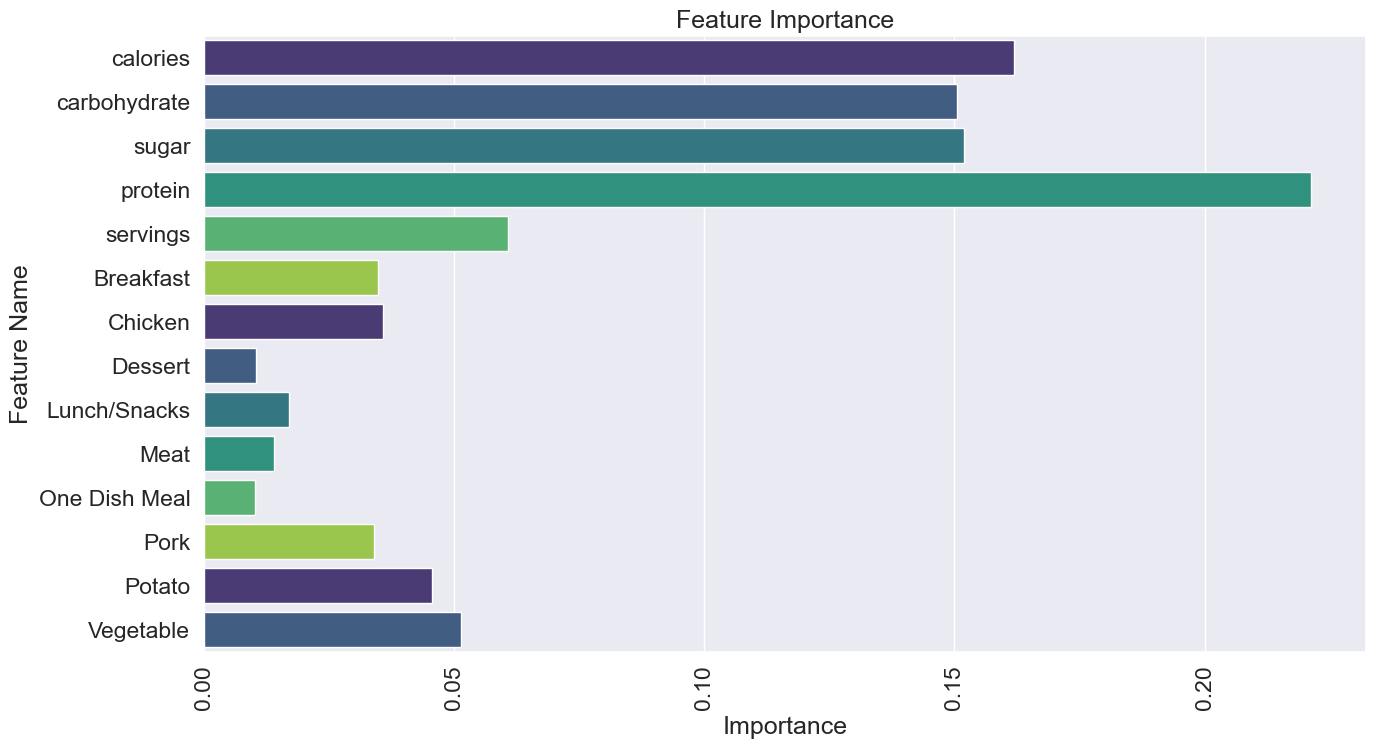

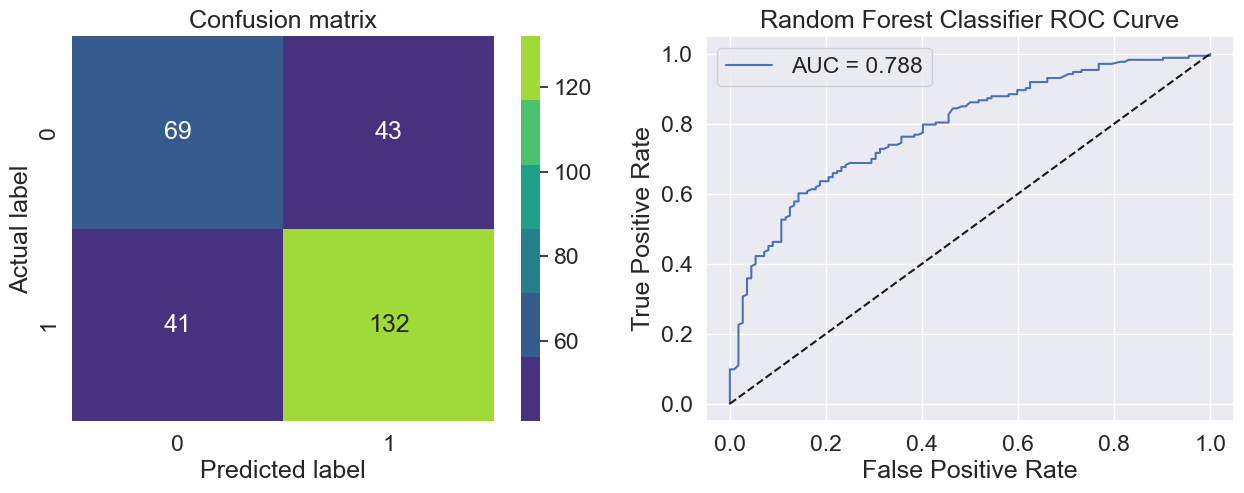

RandomForestClassifier Precision Score: 75.4%
RandomForestClassifier Precision Cross Val Score: 74.9%
RandomForestClassifier ROC AUC: 78.8%


In [ ]:
rf = RandomForestClassifier(n_estimators=400, random_state=seed)
rf.fit(X_train_scaled, y_train)

rf_y_pred = rf.predict(X_test_scaled)
rf_y_pred_prob = rf.predict_proba(X_test_scaled)[:,1]
rf_fpr, rf_tpr, rf_tresholds = roc_curve(y_test, rf_y_pred_prob)
rf_auc_score = auc(rf_fpr,rf_tpr)
rf_cv = cross_val_score(rf,X_train_scaled,y_train, scoring='precision', cv=5)
rf_cv_score = rf_cv.mean()*100 

rf_results  = pd.DataFrame({
    'model': 'Random Forest Classifier',
    'Precision':precision_score(y_test,rf_y_pred)*100,
    'AUC':rf_auc_score*100,
    'CV Precision': rf_cv_score
}, index=[0])



show_plots(rf_y_pred, rf_fpr,rf_tpr, rf_auc_score,rf.feature_importances_, 'Random Forest Classifier')

print(f"RandomForestClassifier Precision Score: {rf_results['Precision'][0]:.1f}%")
print(f"RandomForestClassifier Precision Cross Val Score: {rf_cv_score:.1f}%")
print(f"RandomForestClassifier ROC AUC: {rf_results['AUC'][0]:.1f}%")


In [ ]:
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.63      0.62      0.62       112
           1       0.75      0.76      0.76       173

    accuracy                           0.71       285
   macro avg       0.69      0.69      0.69       285
weighted avg       0.70      0.71      0.70       285



Differently from the Logistic Regression, the key features for predicting with the Random Forest Classifier are protein, sugar, carbohydrate, and calories. 

The RandomForestClassifier model yields a precision score of 77.1%, a precision cross val score of 74.7% and a roc auc score of 79.7%. These values indicate a slightly lower performance compared to the Logistic Regression model across all metrics.



# 6. Results and Discussion

## 6.1 Model performance and insights

In [ ]:
baseline_val = df_filled['high_traffic'].mean()*100
baseline = pd.DataFrame({'model':'Current Method','Precision':baseline_val, 'AUC':50,
                         'CV Precision':baseline_val}, index=[2])
results_df = pd.concat([lr_results,rf_results,baseline]).reset_index(drop=True).sort_values('Precision')
results_df.round(1)

,model,Precision,AUC,CV Precision
2,Current Method,60.6,50.0,60.6
1,Random Forest Classifier,75.4,78.8,74.9
0,Logistic Regression,79.1,82.3,80.7


Above we see a summary of each model's evaluation metrics. The ROC AUC score for random guessing would be 0.5.

The Logistic Regression model outperforms the Random Forest Classifier in terms of precision, roc auc, and cross-validation precision scores. This highlights the effectiveness and reliability of the Logistic Regression model in predicting high traffic recipes in comparison to the RandomForestClassifier model.

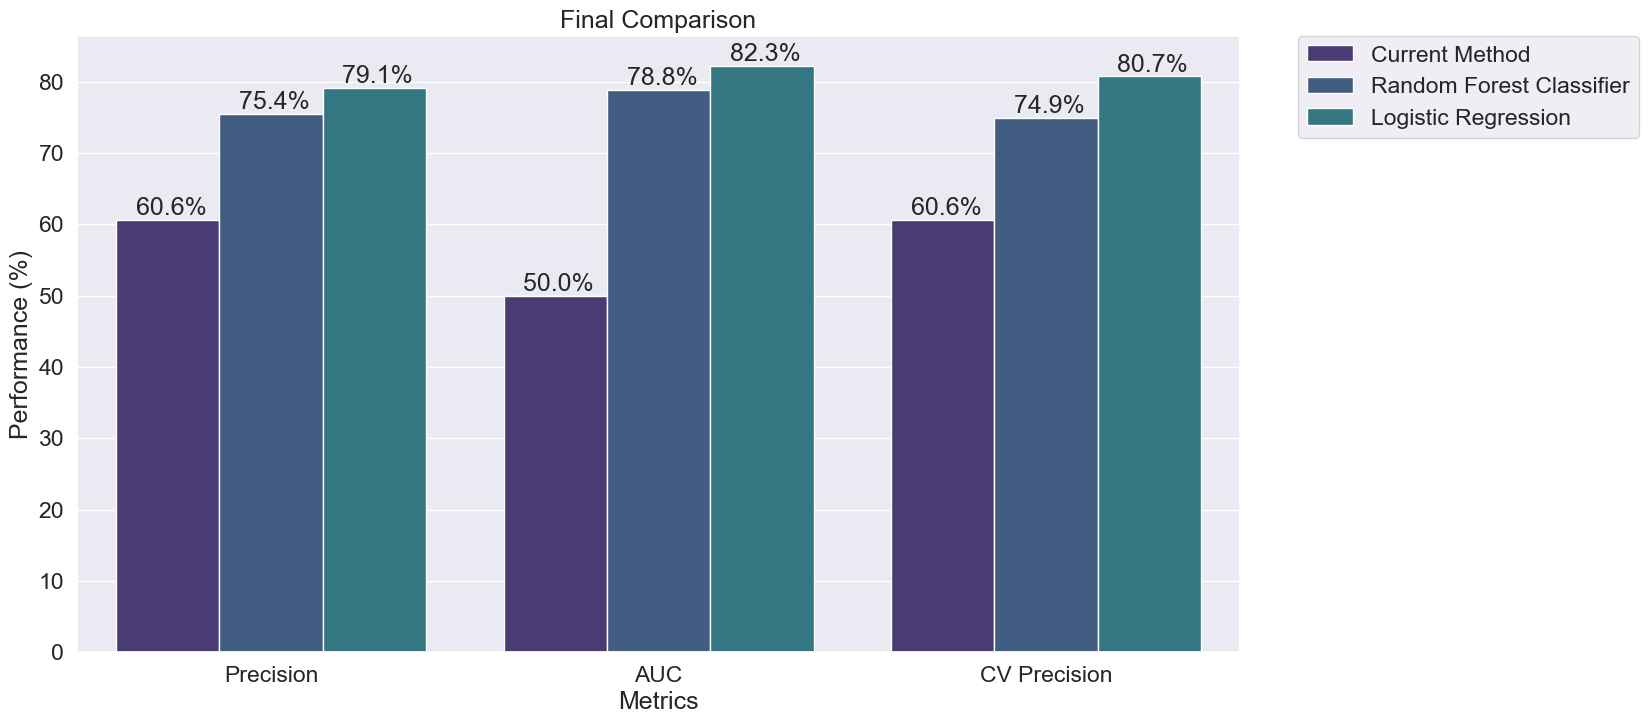

In [ ]:
df_melted = results_df.melt(id_vars='model', var_name='metric', value_name='value')
fig, ax = plt.subplots(1)
sns.barplot(data=df_melted, y='value',x='metric',hue='model', palette=color)
ax.set_title('Final Comparison')
plt.xlabel('Metrics')
plt.ylabel('Performance (%)')
ax.bar_label(ax.containers[0], fmt=' %.1f%%')
ax.bar_label(ax.containers[1], fmt=' %.1f%%')
ax.bar_label(ax.containers[2], fmt=' %.1f%%')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

Today's approach achieve a performance of 60.6% in predicting recipe popularity, which served as our baseline for comparison. However, after implementing logistic regression, we observed a significant improvement, with a performance of 80.7%. This represents a remarkable percentage increase of approximately **33%** over the current method. 

The logistic regression model demonstrated its effectiveness in capturing patterns and making accurate predictions, leading to a substantial enhancement in our ability to identify high traffic recipes. The substantial percentage increase underscores the value and potential impact of utilizing advanced machine learning techniques in recipe popularity prediction.

## 6.2 Recommendations for recipe popularity prediction

- **Feature Importance**: The distinct feature importance patterns between the models suggest that recipe popularity is influenced by a combination of factors. While the category of the recipe plays a role in attracting traffic, the nutritional content of the recipe also contributes to its appeal. By considering both category and nutritional features, we can gain a comprehensive understanding of the factors that drive recipe popularity and make informed decisions in content selection and presentation.

- **Model Selection**: The logistic regression model outperformed the random forest classifier in terms of precision, making it a suitable choice for predicting recipe popularity. It is recommended to prioritize the use of logistic regression in future prediction tasks related to recipe popularity.

- **Data Collection**: To improve the prediction accuracy, consider expanding the dataset by providing already collected data as recipe's title, ingredients, time to make, cost per serving and preparation method as shown on the example recipe. Also, collecting additional data, such as user reviews, ratings, or social media engagement. Incorporating user-generated content can provide valuable insights into user preferences and behavior.

- **Categories**: Based on our analysis, it is evident that certain recipe categories exhibit a higher proportion of high traffic recipes. Categories such as 'Pork', 'Potato', and 'Vegetable' have shown a remarkably high percentage, exceeding 90% of high traffic recipes. Conversely, categories like 'Chicken', 'Breakfast', and 'Beverages' demonstrate a lower prevalence of high traffic recipes. These categories should be approached with caution when prioritizing recipes for maximum visibility and user engagement.

- **Model Refinement**: Experiment with different machine learning algorithms, such as gradient boosting or neural networks, to further enhance prediction performance. Additionally, explore advanced feature engineering techniques, including interaction terms, sentiment analysis of user reviews, or incorporating external data sources related to food trends or seasonal influences.

- **Validation and Testing**: Validate the models on a holdout dataset or conduct a time-series analysis to assess their performance over time and verify their generalization to unseen data. This will provide more confidence in the models' effectiveness and their ability to adapt to changing recipe popularity trends.

By considering these recommendations, continually refining the models, and incorporating additional relevant data, the accuracy and effectiveness of predicting recipe popularity can be improved, allowing for informed decision-making in recipe selection and optimization of website visibility.

# 7. Conclusion

## 7.1 Summary of findings

In this project, we aimed to predict high traffic recipes based on the provided dataset using logistic regression and random forest classifier models. Here are the key findings:

- Logistic Regression outperformed the RandomForestClassifier in terms of precision, roc auc, and cross-validation precision scores, indicating its effectiveness in predicting high traffic recipes.

- The logistic regression model achieved a precision score of 79.1%, roc auc score of 82.6%, and cross-validation precision score of 80.7%, surpassing the baseline of 60.6%.

- Recipe popularity is determined by multiple factors. By taking into account both the category and nutritional features, we can develop a comprehensive understanding of the elements that drive recipe popularity.


## 7.2 Limitations and future directions

Limitations:

- The dataset had a relatively small number of features, which may have limited the model's ability to capture the full complexity of recipe popularity.

- The dataset may not have included all relevant factors that contribute to recipe popularity, such as user reviews, ingredient availability, or seasonality.

- The imputation of missing values may have introduced some degree of bias, even though we used the median of each recipe category to impute missing values.

Future Directions:

- Including already collected data as recipe's title, ingredients, time to make, cost per serving and preparation method as shown on the example recipe.

- Collecting additional data, including user reviews, ingredient popularity, and seasonal trends, could provide more comprehensive insights into recipe popularity.

- Exploring more advanced machine learning models, such as gradient boosting or neural networks, may improve prediction performance and capture complex relationships.

- Conducting more in-depth feature engineering, including creating interaction terms or incorporating external data sources, could enhance the models' ability to predict recipe popularity.

- Evaluating the models' performance on a holdout validation set or conducting a time-series analysis to capture temporal patterns could provide more robust insights.

- Incorporating natural language processing techniques to analyze recipe descriptions and extract relevant features may improve prediction accuracy.

- A/B testing is a powerful tool to evaluate the effectiveness of different strategies or features in attracting user engagement. Tasty Bytes should consider implementing A/B testing to compare the performance of different recipe recommendations, page layouts, or other website features. This iterative approach allows for data-driven decision-making and continuous improvement.

- Collaboration between the product team and data scientists is crucial. Regular communication and knowledge sharing enable better understanding of business objectives and help align data science efforts with company goals.

By addressing these limitations and exploring future directions, further improvements can be made in predicting high traffic recipes and providing valuable insights for the product team to enhance recipe selection and website visibility.